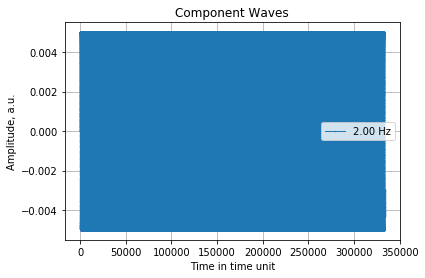

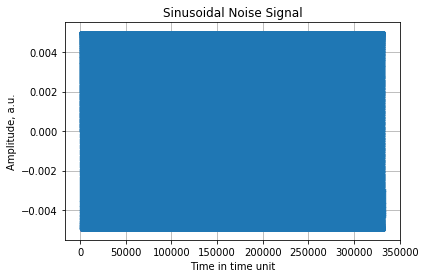

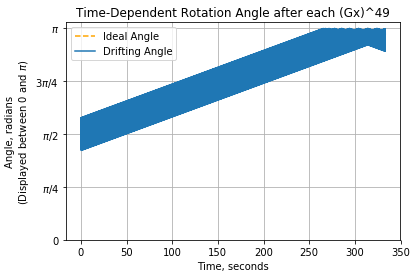

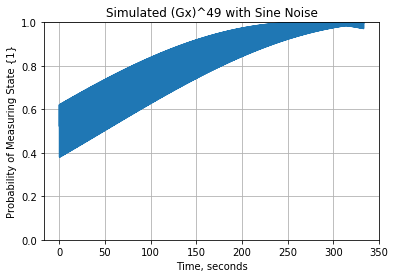

Time per sample/timestep: 0.0167
Samples per second: 60.00
Counts per timestep (sample): 1
Total Samples/Timesteps: 19999
Total time of Data Collection: 333.3 s


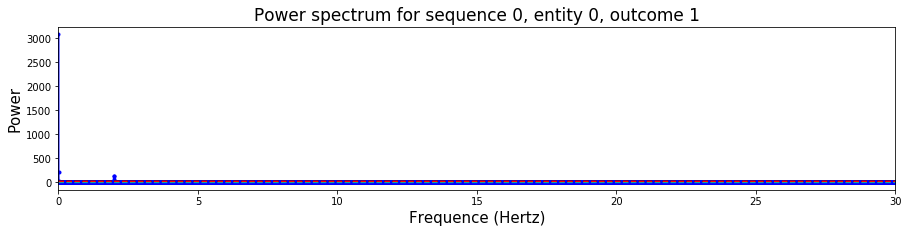

#1 Frequency: 0.0015 Hz
#2 Frequency: 0.0030 Hz
#3 Frequency: 2.0011 Hz
#4 Frequency: 1.9981 Hz
#5 Frequency: 2.0026 Hz
Highest frequency tested is 29.998 Hz


In [6]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data, gate_string_to_list
from drift_file_io import drift_input, calculate_average_timestep, merge_lines
savepath = None

###########################################Manipulate variables here ###############################################
gate_list = gate_string_to_list("(Gx)^49")
nSamples = 20000  #total samples to take for each measurement
nCounts = 1   #total shots to take at one; =nSamples: same noise, probabilities for all repeats; =1, new experiment & noise for each count
time_per_count = 1/60 #seconds
time_units = 1e-3 #seconds
res = 1
noise_type='Sine' #Sine, Random Walk, Telegraph
plot_noise=True
add_noise=None
walking_amp = 0.0001
freq_list=[2]
amp_list=[0.005]
phase_list=[0]
freq_list = tuple(freq_list)
amp_list = tuple(amp_list)
phase_list = tuple(phase_list)
telegraph_amp = 0.02
start_f = 0.1
stop_f = 2
fluctuators= 40
dc_angle_offset=0
constant_linear_drift=0.005 #rad/s
#################################################################################################################
##################################################################################################################
##############################################################################################################
#Don't change anything below this line for regular program operation
#calculate timestep (per sample) for simulated data, extract avg from experimental data
ones_count_array, zeros_count_array,timestamp_array, probs_array, ideal_angles, angles, sig\
= create_data(time_per_count, nSamples, nCounts, gate_list, \
                                                                                    time_units, noise_type, walking_amp, telegraph_amp,\
                                                                                    res, freq_list, amp_list, phase_list, start_f, stop_f,\
                                                                                    fluctuators,plot_noise,add_noise,None,dc_angle_offset, constant_linear_drift)
time_per_sample = nCounts*time_per_count #time for a full sample (one bitstring) of data

    
#calculate results and print relevant information
print("Time per sample/timestep: {:.4f}".format(time_per_sample))
print("Samples per second: {:.2f}".format(1/time_per_sample))
nCounts = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
print("Counts per timestep (sample): {}".format(nCounts))
print("Total Samples/Timesteps: {}".format(len(timestamp_array)))
print("Total time of Data Collection: {} s".format(timestamp_array[len(timestamp_array) - 1] - timestamp_array[0]))
drifted = drift.do_basic_drift_characterization(ones_count_array, counts=nCounts, timestep=time_per_sample,timestamps=timestamp_array, verbosity=0)
drifted.plot_power_spectrum(sequence=0, entity=0, outcome=1, savepath=savepath)

#analyze the frequency-power spectrum
frequencies = list(drifted.frequencies)
power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
grouped = []
for i in range(len(frequencies)):
    grouped.append((frequencies[i], power_spectrum[i]))
sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
num_points = 5
for i in range(num_points):
    print("#{} Frequency: {:.4f} Hz".format(i+1, sorted_groups[i][0]))
#print("Spacing is {:.4f} Hz".format(frequencies[1]-frequencies[0]))

print("Highest frequency tested is {:.3f} Hz".format(frequencies[len(frequencies) - 1]))   